# Thresholding, masking and preprocessing


Fluorescence datasets ideally reflect a relationship between the pixels in an image and the location and local density of your fluorescent molecule in a sample. However, properties of the detectors, optics, or even the samples can confound direct interpretation of this data. Here we will present some operations that can mitigate these effects to achieve robust hypothesis testing.

Today, we will explore ways to automatically define the ROIs (regions of interest) and deal with aberrations in the data that can make such analysis difficult on raw data

Episode 1: Load, understand and visualize the data  
    Mostly a recap. of lesson 1


Episode 2: Thresholding
> a) Global threshold and masking     
b) Automatic threshold detection  

Episode 3: Filtering and background subtraction
> a) The need for preprocessing  
b) Filtering out noise   
c) Background subtraction  
d) Combining preprocessing + thresholding  

***
# Episode 1: Load, understand and visualize the data

First, let's import packages and set some plotting defaults


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import skimage


### Episode 1a) Load the images


#### <font color='red'> Exercise</font>: load lesson 2 data  
Use what you learned in Lesson 1 to load the Lesson 2 image data: 'HAC-Cit-KRAB+dox_s41_t60.tif' and call it raw_data  
Hint:   
Step 1) Find the data directory  
Step 2) use skimage.io.imread to load the image data  



In [47]:
data_fn = 'HAC-Cit-KRAB+dox_s41_t60.tif'
data_dir = '/Users/mhturner/Documents/GitHub/StanfordBIOS254-2019/Data/L2Data'
import os
dir_contents = os.listdir(data_dir)
print(dir_contents)

['HAC-Cit-KRAB+dox_s41_t60.json', 'HAC-Cit-KRAB+dox_s41_t60.tif']


In [48]:
from skimage.io import imread

raw_data = imread(os.path.join(data_dir, data_fn))


Check the dimensions of the data

In [4]:
raw_data.shape

(512, 512, 3)

### Episode 1b) Load the metadata

Load the metadata, which is in JSON format

In [5]:
import json
metadata_fn = 'HAC-Cit-KRAB+dox_s41_t60.json'
with open(os.path.join(data_dir, metadata_fn), mode='r') as metadata_file:
    metadata = json.load(metadata_file)

Take a look at the metadata dictionary

In [6]:
for key, value in metadata.items():
   print(key + ': ' + str(value))

axes: ['XYC']
channels: ['DIC', 'YFP', 'RFP']
pixel_size: ['1', '1']
data: ['01/01/2019']
image_preprocessing: ['none']
condition: ['+dox']


Let's re-label the slices with names, instead of numbers.

In [7]:
data = {}
for idx, channel in enumerate(metadata['channels']):
    data[channel] = raw_data[:,:,idx]
    print(channel)

DIC
YFP
RFP


#### <font color='red'> Exercise</font>: Visualize the images  
Use what you learned in lesson 1 to display each channel, and label each image panel with the channel name

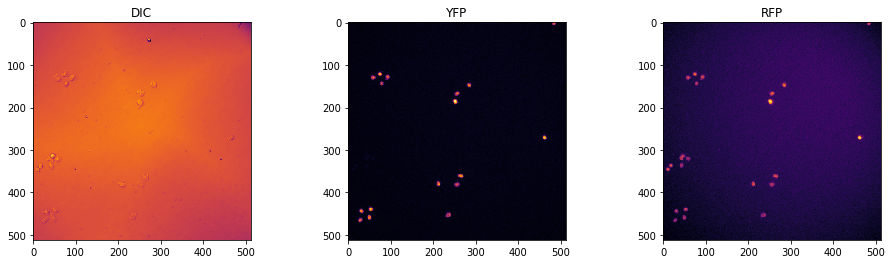

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
for idx, channel in enumerate(metadata['channels']):
    ax[idx].imshow(data[channel], cmap='inferno')
    ax[idx].set_title(channel)


***
# Episode 2: Thresholding and masking

Suppose we want to automatically select regions of interest (ROIs) from these images to, for example, count cells or measure the intensity of some fluorescent signal within the cells. One simple way to start to do this is by thresholding the image based on the pixel intensity.

To illustrate, we will focus on the YFP channel.   
Let's first split up our channels into descriptive variable names...

In [9]:
brt_data = data['DIC']
ch1_data = data['YFP']
ch2_data = data['RFP']

### Part 2a) Global thresholding and masking


Let's create a __mask__, which is a binary image where values of 1 correspond to image pixels that exceed a given threshold and pixels whose intensity is below the threshold are assigned a value of 0  
How should we decide on the threshold value? First let's get a sense of the range of pixel intensities present in the image by looking at a histogram

Text(0, 0.5, 'Count')

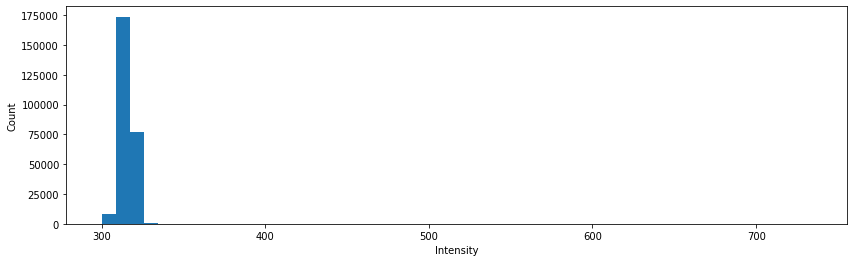

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.hist(ch1_data.flatten(), bins=50) 
ax.set_xlabel('Intensity')
ax.set_ylabel('Count')
# ax.set_yscale('log')

OK now let's pick a threshold and make a mask...

Text(0.5, 1.0, 'Mask')

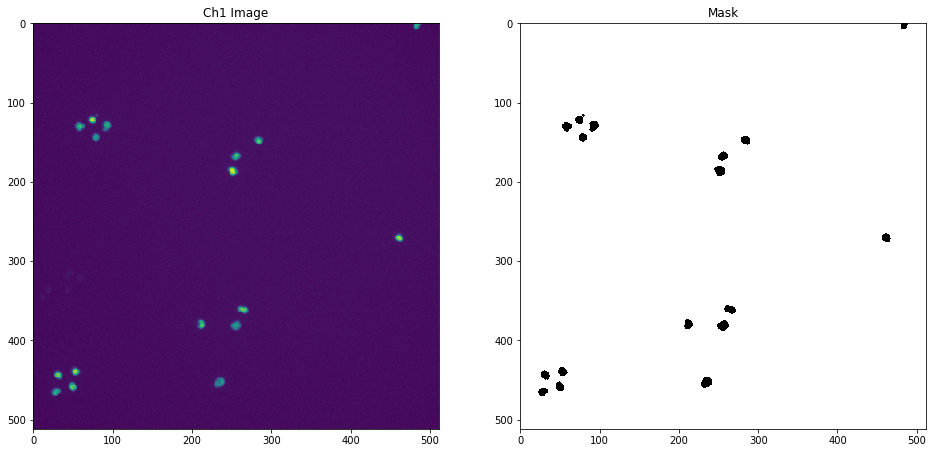

In [14]:
thresh = 350 #325, 400
 
mask = np.zeros(ch1_data.shape)
mask[ch1_data >=thresh] = 1

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].imshow(ch1_data)
ax[0].set_title('Ch1 Image')

ax[1].imshow(mask, vmin=0, vmax=1, cmap='Greys')
ax[1].set_title('Mask')


This is nice but the idea was to *automate* this process. How do we choose an appropriate threshold value without the need for user input? Luckily there exist several auotmatic threshold calculation methods that are included in the scikit-image library. Generally these automatic threshold methods rely on the distribution of pixel intensity values.

### Part 2b) Automatic threshold detection  

Now let's use some built-in automatic threshold algorithms to define a threshold for our image  
https://scikit-image.org/docs/dev/api/skimage.filters.html  
https://en.wikipedia.org/wiki/Otsu%27s_method  


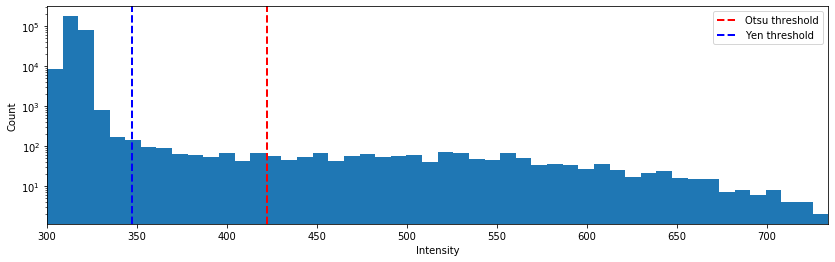

In [15]:
from skimage.filters import threshold_otsu, threshold_yen

thresh_otsu = threshold_otsu(ch1_data)
thresh_yen = threshold_yen(ch1_data) 

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.hist(ch1_data.flatten(), bins=50)

plt.axvline(thresh_otsu, ls='--', lw=2, c='r', label='Otsu threshold') 
plt.axvline(thresh_yen, ls='--', lw=2, c='b', label='Yen threshold') 
ax.legend()
ax.set_xlabel('Intensity')
ax.set_ylabel('Count')
ax.set_xlim(ch1_data.min(),ch1_data.max())
ax.set_yscale('log')

#### <font color='red'> Exercise</font>: make a mask function
First, since we will be doing this a lot, let's define our own function to calculate a mask given: 1) the original image and 2) a threshold value. give the function an informative name

In [16]:
def get_mask(im, threshold):
    mask = np.zeros(im.shape)
    mask[im >=threshold] = 1
    return(mask)

Now let's look at the masks generated using these automatic thresholds. 

Text(0.5, 1.0, 'Yen threshold')

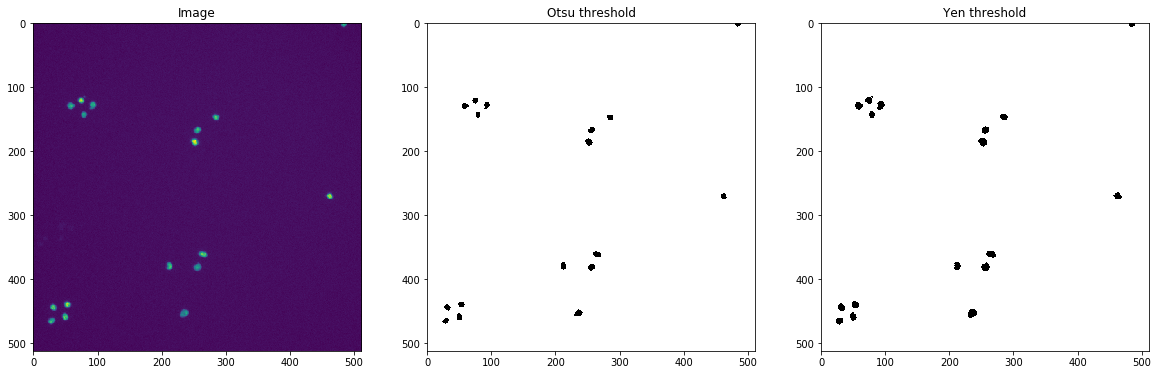

In [17]:
mask_otsu = get_mask(ch1_data, thresh_otsu)
mask_yen = get_mask(ch1_data, thresh_yen)

fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(ch1_data)
ax[0].set_title('Image')

ax[1].imshow(mask_otsu, vmin=0, vmax=1, cmap='Greys')
ax[1].set_title('Otsu threshold')

ax[2].imshow(mask_yen, vmin=0, vmax=1, cmap='Greys')
ax[2].set_title('Yen threshold')

***
# Part 3: Filtering and background subtraction

To illustrate the need for preprocessing, let's try to automatically threshold the other fluorescent channel of our data

Text(0.5, 1.0, 'Yen threshold')

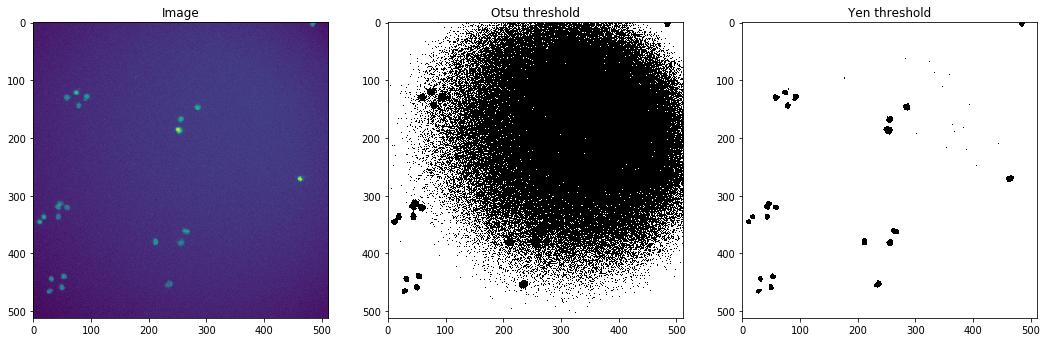

In [20]:
thresh_otsu = threshold_otsu(ch2_data)
thresh_yen = threshold_yen(ch2_data) 

mask_otsu = get_mask(ch2_data, thresh_otsu)
mask_yen = get_mask(ch2_data, thresh_yen)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(ch2_data)
ax[0].set_title('Image')

ax[1].imshow(mask_otsu, vmin=0, vmax=1, cmap='Greys')
ax[1].set_title('Otsu threshold')

ax[2].imshow(mask_yen, vmin=0, vmax=1, cmap='Greys')
ax[2].set_title('Yen threshold')

Uh oh - our simple automatic thresholding fails for the other two channels. There are at least two reasons for these failures:  
1) Salt & pepper, speckly noise  
2) A background due to uneven illumination or other optical aberrations

We'll try to get rid of the salt and pepper noise first. We'll do that by __filtering__

We need to import packages and filters:

In [23]:
from skimage.filters.rank import minimum as min_filter
from skimage.filters.rank import median as median_filter
from skimage.morphology import disk

### Part 3b) Filtering out noise


Now, try using a median filter to remove the salt-pepper noise. Can you see differences in the images? Play with the filter size and see how that affects the filtering.

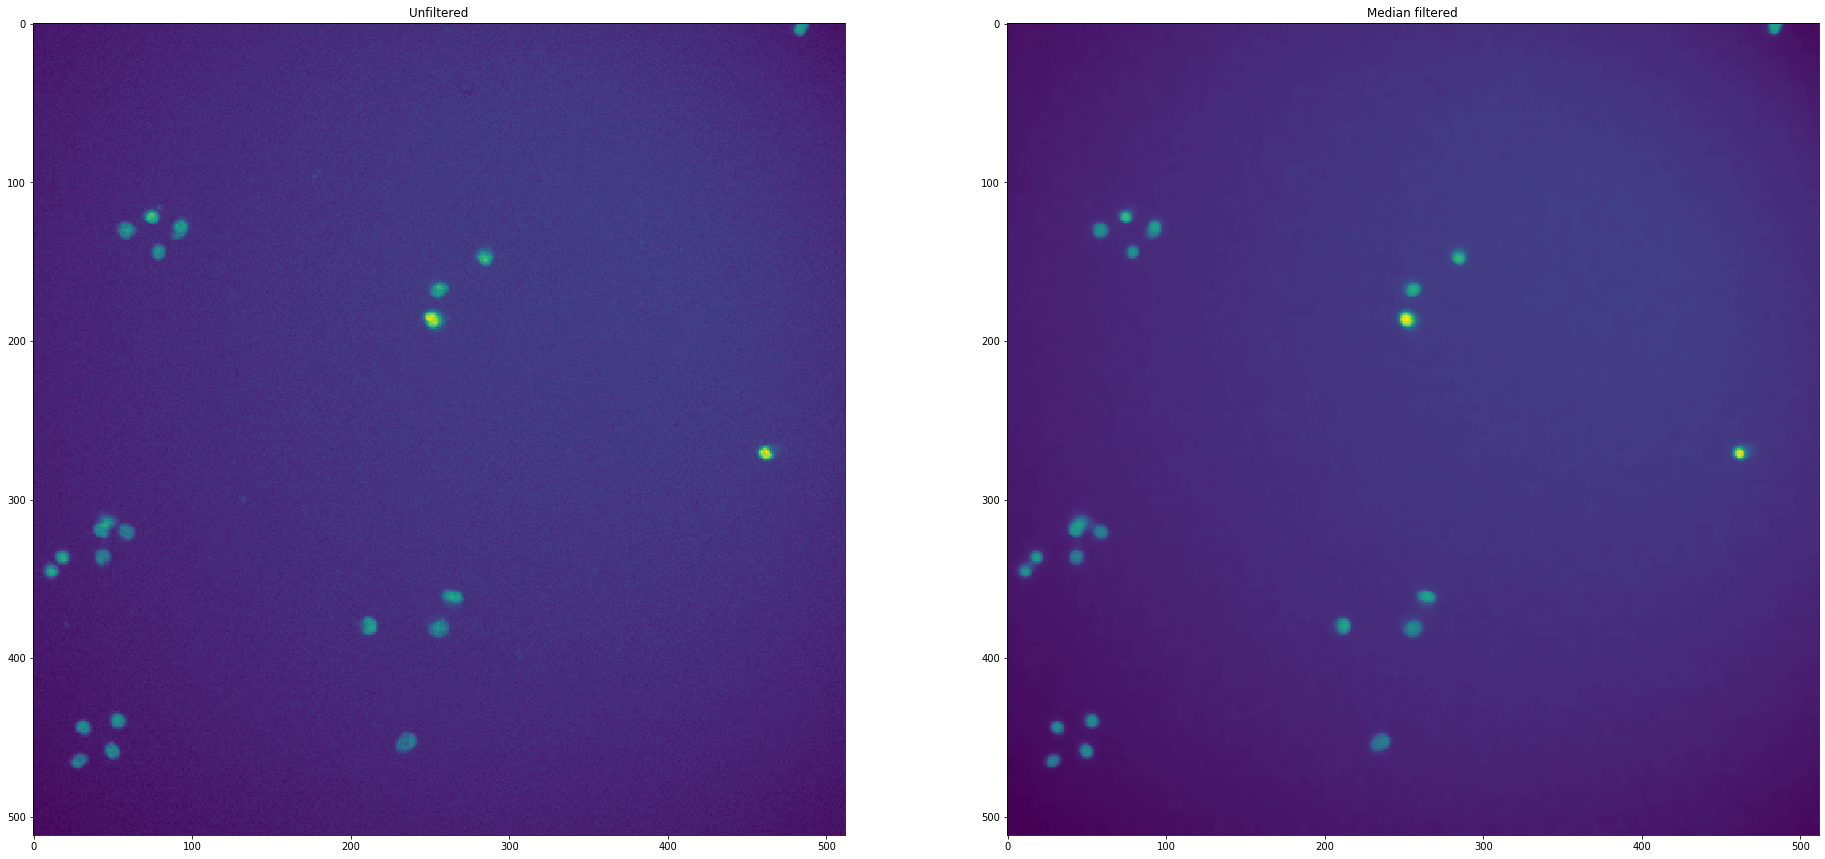

In [24]:
f_size = 4
ch2_filtered = median_filter(ch2_data, disk(f_size))

fig, ax = plt.subplots(1, 2, figsize=(32, 25))
ax[0].imshow(ch2_data)
ax[0].set_title('Unfiltered')
ax[1].imshow(ch2_filtered)
ax[1].set_title('Median filtered');

### Part 3c) Background subtraction

We need to remove the un-even illumination. To do this we will subtract a background image, hopefully leaving intact the image structure we care about. The radius should be set to at least the size of the largest object that is not part of the background.

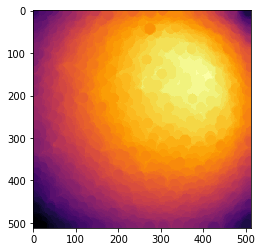

In [25]:
# the radius should be set to at least the size of the largest object that is not part of the background
filter_radius = 12
ch2_background = min_filter(ch2_filtered, disk(filter_radius))
plt.imshow(ch2_background, cmap='inferno', interpolation = 'none')#, vmin = 0, vmax = 3000)

Next, let's substract out the background from the dataset.

Text(0.5, 1.0, 'Filtered, background subtracted')

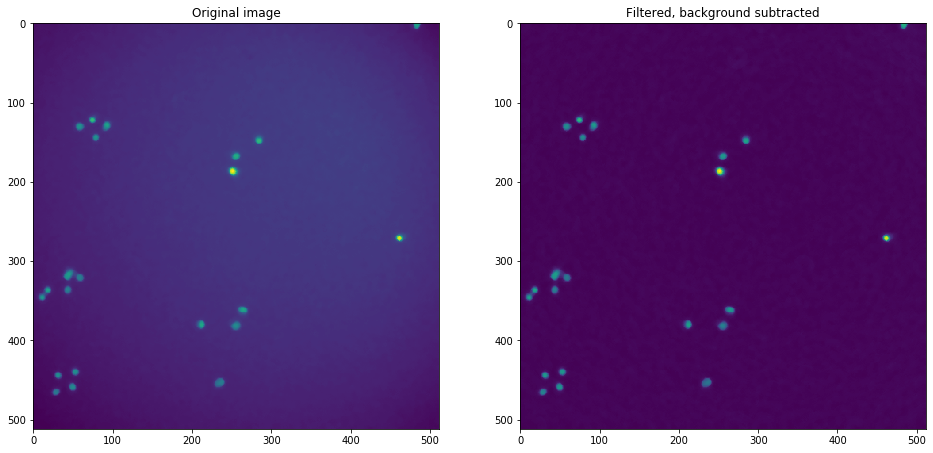

In [26]:
ch2_bgs = ch2_filtered - ch2_background
ch2_bgs[ch2_bgs<0] = 0

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(ch2_filtered, interpolation = 'none')
ax[0].set_title('Original image')
ax[1].imshow(ch2_bgs, interpolation = 'none')
ax[1].set_title('Filtered, background subtracted')

With our pre-processed dataset, let's try the thresholding again.

Text(0.5, 1.0, 'Yen threshold')

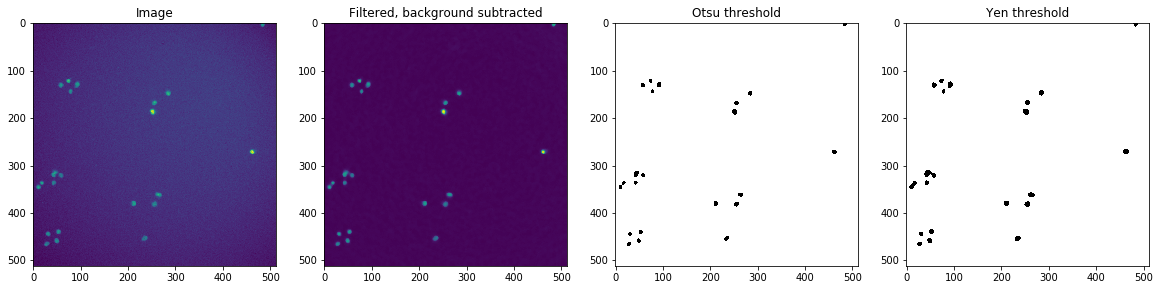

In [28]:
thresh_otsu = threshold_otsu(ch2_bgs)
thresh_yen = threshold_yen(ch2_bgs) 

mask_otsu = get_mask(ch2_bgs, thresh_otsu)
mask_yen = get_mask(ch2_bgs, thresh_yen)

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(ch2_data)
ax[0].set_title('Image')

ax[1].imshow(ch2_bgs)
ax[1].set_title('Filtered, background subtracted')

ax[2].imshow(mask_otsu, vmin=0, vmax=1, cmap='Greys')
ax[2].set_title('Otsu threshold')

ax[3].imshow(mask_yen, vmin=0, vmax=1, cmap='Greys')
ax[3].set_title('Yen threshold')

### Part 3d) Combining preprocessing + masking   
#### <font color='red'> Exercise</font>: Make functions for an image processing pipeline   
We have already defined a simple function to return a mask given an image and a threshold, try to make a preprocessing function that could be used before the masking function in an image processing pipeline. This function should remove salt and pepper noise and do some background subtraction as well

In [29]:
def get_preprocessed_image(raw_data):
    ...
    
    return preprocessed_data

In [38]:
# ANSWER:
def get_preprocessed_image(raw_data):
    noise_filter_radius = 4
    denoised_data = median_filter(raw_data, disk(noise_filter_radius))
    
    background_filter_radius = 12
    background = min_filter(denoised_data, disk(background_filter_radius))
    
    preprocessed_data = denoised_data - background
    preprocessed_data[preprocessed_data<0] = 0
    
    return preprocessed_data
    

Let's put these two functions together and make a mask from noisy data in just a couple lines of code

Text(0.5, 1.0, 'Mask')

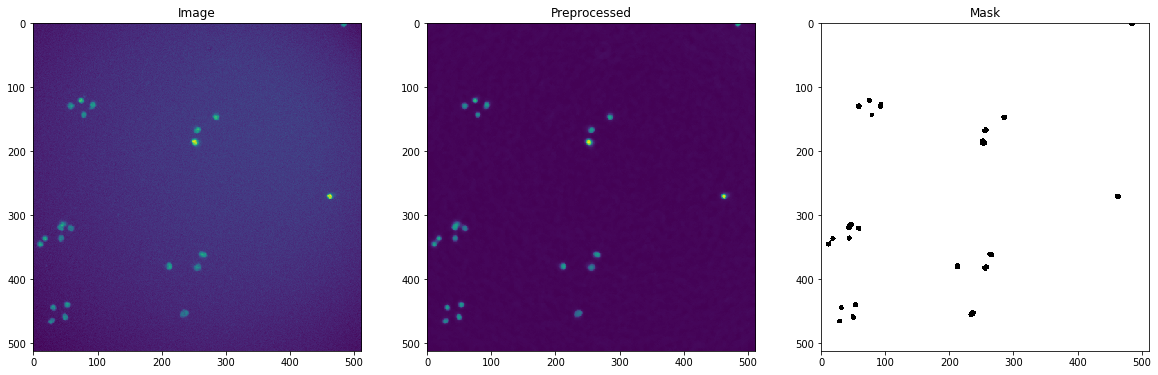

In [39]:
preprocessed_data = get_preprocessed_image(ch2_data)
thresh = threshold_otsu(preprocessed_data)
mask = get_mask(preprocessed_data, thresh)

fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(ch2_data)
ax[0].set_title('Image')

ax[1].imshow(preprocessed_data)
ax[1].set_title('Preprocessed')

ax[2].imshow(mask, vmin=0, vmax=1, cmap='Greys')
ax[2].set_title('Mask')


### The limits of global intensity thresholding

We haven't yet tried any processing on our brightfield channel. Let's see how the methods we tried above work on these data

Text(0.5, 1.0, 'Mask')

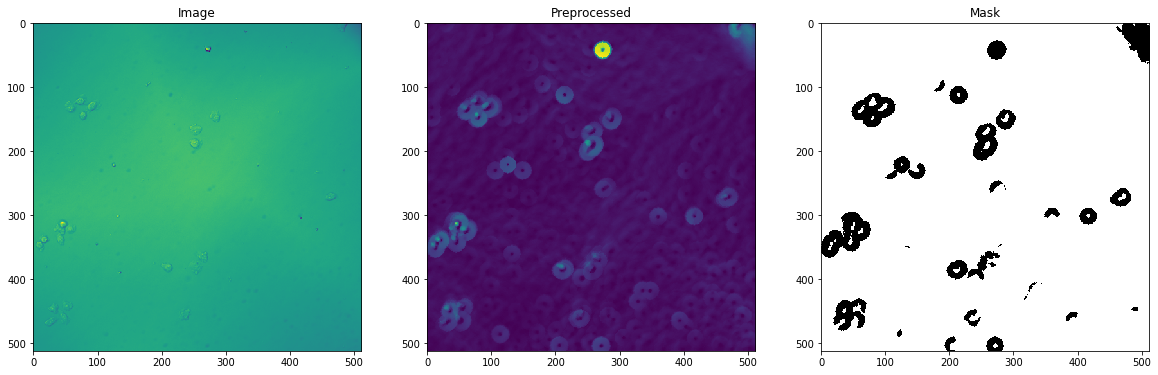

In [44]:
preprocessed_data = get_preprocessed_image(brt_data)
thresh = threshold_yen(preprocessed_data)
mask = get_mask(preprocessed_data, thresh)

fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(brt_data)
ax[0].set_title('Image')

ax[1].imshow(preprocessed_data)
ax[1].set_title('Preprocessed')

ax[2].imshow(mask, vmin=0, vmax=1, cmap='Greys')
ax[2].set_title('Mask')

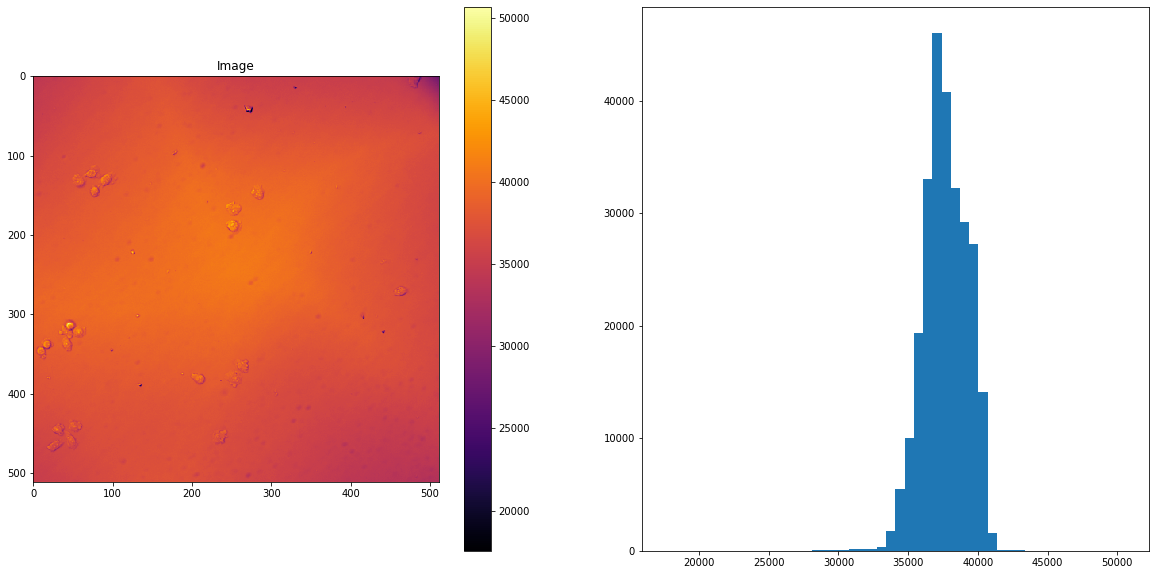

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
im_plot = ax[0].imshow(brt_data, cmap='inferno')
ax[0].set_title('Image')
fig.colorbar(im_plot,ax=ax[0])
ax[1].hist(brt_data.flatten(), bins=50);
# ax[1].set_yscale('log')

#### Edge / contrast-enhancing filters   
The above methods rely on the intensity of each pixel, but we see the cells in the DIC channel with our eyes because of the contrast in the image. To pick out high contrast regions we need to use a edge-detection filter

Text(0.5, 1.0, 'Sobel filtered')

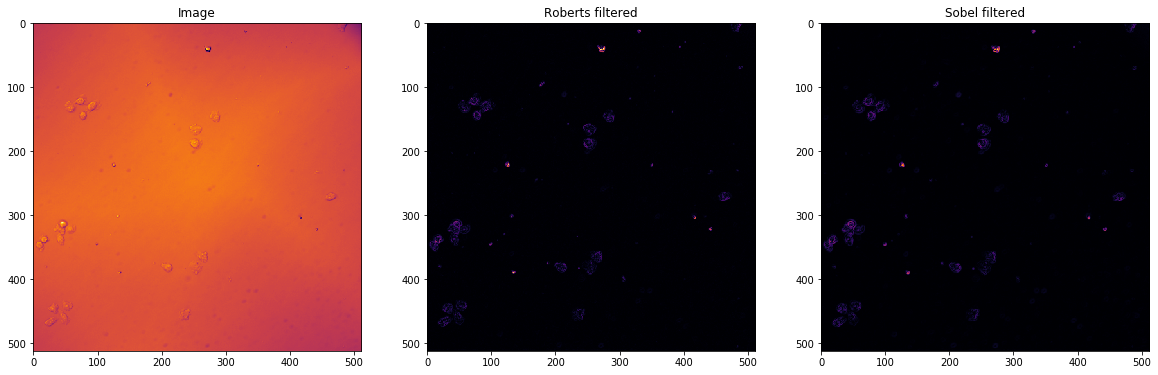

In [46]:
from skimage.filters import roberts, sobel
sigma = 3
brt_roberts = roberts(brt_data)
brt_sobel = sobel(brt_data)

fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(brt_data, cmap='inferno')
ax[0].set_title('Image')

ax[1].imshow(brt_roberts, cmap='inferno')
ax[1].set_title('Roberts filtered')

ax[2].imshow(brt_sobel, cmap='inferno')
ax[2].set_title('Sobel filtered')

Text(0.5, 1.0, 'Mask')

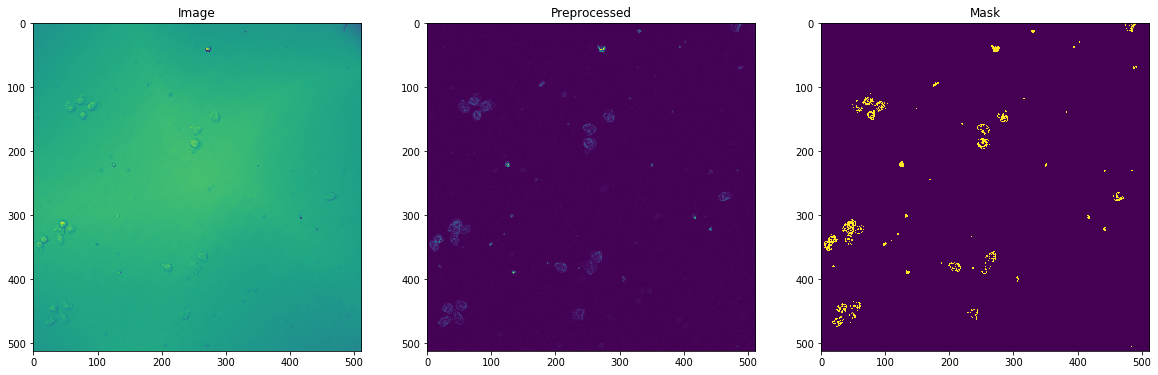

In [43]:
thresh = threshold_otsu(brt_roberts)
mask = get_mask(brt_roberts, thresh)

fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(brt_data)
ax[0].set_title('Image')

ax[1].imshow(brt_roberts)
ax[1].set_title('Preprocessed')

ax[2].imshow(mask, vmin=0, vmax=1, cmap='Greys')
ax[2].set_title('Mask')